# Gather & Process Model Outputs:

# Load data from .dat

Read run00 .dat from model output files

Outputs: Data_.nc (model outputs); Topo_.nc (topography from Plot_Model); Out_.nc (processed data: transports, variables along circuit...)

In [19]:
# %matplotlib notebook
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sp
import matplotlib.pyplot as plt
import scipy.io as sio
import io

from dask.diagnostics import ProgressBar

In [20]:
# put which experiment do we want to extract data from
Expnum = '5' 
datafilepath = '/Volumes/GeneralBackup/backup_20210627/Desktop/WORK/MODEL/Onelayer/try5/Par_1_largedomain/'

In [21]:
# path to model outputs

datafilename = 'run00' + Expnum + '.dat'

# path to model topography 
Topo_filepath = datafilepath
Topo_filename = 'Topo_' + Expnum + '.nc'

# # path to circuit
# Circuit_filepath = '/Users/tantanmeow/MODEL/Onelayer/try4/para/wide_wideisland_nodiff/'
# Circuit_filename = 'circuit.mat'
# #how many data in circuit; S1 locate; S2 locate; S3 locate
# S = [228, 0, 114, -1] 

# # path to Gill's prediction
# Gill_path = '/Users/tantanmeow/WORK/2018-2019/Samoan/STan/GillMod/'
# Gill_name = 'Gill_predict.mat'

# path to saved data
outfilepath = datafilepath

Data_filename = 'Data_' + Expnum + '.nc'
Out_filename = 'Out_' + Expnum + '.nc'


NOTICE: here we ignore the fact that h and u/v are not at the same grid!

In [22]:
# python function equavalent to the Matlab's code 'fread'
 # by Nick from Stackoverflow: 
 # https://stackoverflow.com/questions/34026326/ensuring-python-equivalence-of-matlabs-fread

def fread(fid, nelements, dtype):
     if dtype is np.str:
         dt = np.uint8  # WARNING: assuming 8-bit ASCII for np.str!
     else:
         dt = dtype

     data_array = np.fromfile(fid, dt, nelements)
     data_array.shape = (nelements, 1)

     return data_array


In [23]:
# read binary data from a .dat file

def Onelayer_modeloutput(filepath, filename):
    
    runid = filepath + filename
    
    fid = open(runid,'rb') # 'rb' is for binary data
    #'r', encoding='unicode_escape')# ISO-8859-1
    
    # read all the initial information
    hr1    = fread(fid, 1, np.int32);
    nout   = fread(fid, 1, np.int32);
    tend   = fread(fid, 1, np.float64);
    hr1    = fread(fid, 1, np.int32);
    hr1    = fread(fid, 1, np.int32);
    mx     = fread(fid, 1, np.int32);
    my     = fread(fid, 1, np.int32);
    meqn   = fread(fid, 1, np.int32);
    mbc    = fread(fid, 1, np.int32);
    sx     = fread(fid, 1, np.int32);
    ex     = fread(fid, 1, np.int32);
    sy     = fread(fid, 1, np.int32);
    ey     = fread(fid, 1, np.int32);  
    hr1    = fread(fid, 1, np.int32);
    hr1    = fread(fid, 1, np.int32);
    dt     = fread(fid, 1, np.float64);
    dx     = fread(fid, 1, np.float64);
    dy     = fread(fid, 1, np.float64);
    gamma  = fread(fid, 1, np.float64);
    cf     = fread(fid, 1, np.float64);
    cb     = fread(fid, 1, np.float64);  
    y1     = fread(fid, 1, np.float64);  
    hr1    = fread(fid, 1, np.int32);
    hr1    = fread(fid, 1, np.int32);
    ixbc   = fread(fid, 1, np.int32);
    iybc   = fread(fid, 1, np.int32);
    hr1    = fread(fid, 1, np.int32);
    hr1  = fread(fid, 1, np.int32);
    x    = fread(fid, mx.tolist()[0][0], np.float64); # ndarray to int
    hr1  = fread(fid, 1, np.int32);
    hr1  = fread(fid, 1, np.int32);
    y    = fread(fid, my.tolist()[0][0], np.float64);
    hr1  = fread(fid, 1, np.int32);
    hr1  = fread(fid, 1, np.int32);
    b    = fread(fid, mx.tolist()[0][0]*my.tolist()[0][0], np.float64);
    hr1  = fread(fid, 1, np.int32);
    hr1  = fread(fid, 1, np.int32);
    cbxy = fread(fid, mx.tolist()[0][0]*my.tolist()[0][0], np.float64);
    hr1  = fread(fid, 1, np.int32);

    x    = np.reshape(x, (mx.tolist()[0][0], 1))
    y    = np.reshape(y, (my.tolist()[0][0], 1))
    b    = np.reshape(b, (my.tolist()[0][0], mx.tolist()[0][0]))
    cbxy = np.reshape(cbxy, (my.tolist()[0][0], mx.tolist()[0][0]))
    
    x0 = x[0] - dx/2
    xf = x[-1] + dx/2
    y0 = y[0] - dy/2
    yf = y[-1] + dy/2
    
    H = np.zeros((nout.tolist()[0][0] + 1
                  , my.tolist()[0][0], mx.tolist()[0][0]))
    U = np.zeros((nout.tolist()[0][0] + 1
                  , my.tolist()[0][0], mx.tolist()[0][0]))
    V = np.zeros((nout.tolist()[0][0] + 1
                  , my.tolist()[0][0], mx.tolist()[0][0]))
    B    = np.zeros((my.tolist()[0][0], mx.tolist()[0][0]))
    CB   = np.zeros((my.tolist()[0][0], mx.tolist()[0][0]))
    tim  = np.zeros((nout.tolist()[0][0] + 1, 1))
    
    # start to read modeloutputs that matters
    for i in range(nout.tolist()[0][0] + 1):
        # ** read the h, Qu, Qv fields *****************
        hr1 = fread(fid, 1, np.int32);
        t   = fread(fid, 1, np.float64);
        hr1 = fread(fid, 1, np.int32);
        hr1 = fread(fid, 1, np.int32);
        h   = fread(fid, my.tolist()[0][0]*mx.tolist()[0][0], np.float64);
        hr1 = fread(fid, 1, np.int32);
        hr1 = fread(fid, 1, np.int32);
        qu  = fread(fid, my.tolist()[0][0]*mx.tolist()[0][0], np.float64);
        hr1 = fread(fid, 1, np.int32);
        hr1 = fread(fid, 1, np.int32);
        qv  = fread(fid, my.tolist()[0][0]*mx.tolist()[0][0], np.float64);
        hr1 = fread(fid, 1, np.int32);
        # ******************************************
  
        h   = np.reshape(h, (my.tolist()[0][0], mx.tolist()[0][0]))
        qu  = np.reshape(qu, (my.tolist()[0][0], mx.tolist()[0][0]))
        qv  = np.reshape(qv, (my.tolist()[0][0], mx.tolist()[0][0])) 
        u = qu/h
        v = qv/h
#         u[h<1e-3] = 0.0
#         v[h<1e-3] = 0.0
#         h[h<1e-3] = 0.0
        tim[i] = t
        H[i::] = h
        U[i::] = u
        V[i::] = v  
     
    fid.close()
    
    # build DataArray

    H = xr.DataArray(H, dims=['time', 'y', 'x'], 
                    coords={'time':np.squeeze(tim), 
                            'y': np.squeeze(y), 
                            'x': np.squeeze(x)},
                    attrs={'long_name':'Layer Thickness'})
    U = xr.DataArray(U, dims=['time', 'y', 'x'], 
                    coords={'time':np.squeeze(tim), 
                            'y': np.squeeze(y), 
                            'x': np.squeeze(x)},
                    attrs={'long_name':'Down-to-up Velocity'})
    V = xr.DataArray(V, dims=['time', 'y', 'x'], 
                    coords={'time':np.squeeze(tim), 
                            'y': np.squeeze(y), 
                            'x': np.squeeze(x)},
                    attrs={'long_name':'Right-to-left Velocity'})    
    B = xr.DataArray(b, dims=['y', 'x'], 
                    coords={'y': np.squeeze(y), 
                            'x': np.squeeze(x)},
                    attrs={'long_name':'Bottom Elevation'})
    CB = xr.DataArray(cbxy, dims=['y', 'x'], 
                      coords={'y': np.squeeze(y), 
                              'x': np.squeeze(x)},
                      attrs={'long_name':'Friction coefficient'})
    
    # build Dataset
    data = xr.Dataset({'H': (['time', 'y', 'x'], H),
                       'U': (['time', 'y', 'x'], U),
                       'V': (['time', 'y', 'x'], V),
                       'B': (['y', 'x'], B),
                      'CB': (['y', 'x'], CB)},
                     coords={'time': np.squeeze(tim),
                            'y': np.squeeze(y),
                            'x': np.squeeze(x)},
                     attrs={'title':'Outputs from nondimensional model',
                           'description':'Scales: H~1000 m; L~30 km; T~0.6 d; x -'})

    return data

In [24]:
# read data from .dat

Data = Onelayer_modeloutput(datafilepath, datafilename)


In [25]:
# save thy data

Data.to_netcdf(outfilepath + Data_filename, mode='w')


PermissionError: [Errno 13] Permission denied: b'/Volumes/GeneralBackup/backup_20210627/Desktop/WORK/MODEL/Onelayer/try5/Par_1_largedomain/Data_5.nc'

In [26]:
# read data from netcdf

Data = xr.open_dataset(outfilepath + Data_filename)


In [9]:
# # read info - dissipation coefficient, location of the sill
# runid = datafilepath + 'run00' + Expnum + '.ic'

# # with open(runid) as fp:
# fid = io.open(runid, mode='r')
# for i in range(4):
#     print(fid.readline())
# A = fid.readline()
# yend=A

# if len(A)==13:
#     Cf = float(A[4:7])
#     Cb = float(A[7+2:7+5])
# else:
#     Cf = float(A[4:7+len(A)-13])
#     Cb = float(A[7+len(A)-13+2:7+len(A)-13+5])

# A = fid.readline()
# wc = float(A[12:16])
# hc = float(A[17:21])
# yc = float(A[-5:-1])
# fid.close()

# # # In y-direction:
# #   # Where is the center of the channel?
# # y0 = y[-1] - wc - wc/2
# #   # Where is the joint of the channel and the plateau?
# # yc = y[-1] - 2*wc - wc


# # Topo = xr.Dataset({'Ly': (Ly),
# #                    'xc': (xc),
# #                    'theta_i': (theta_i),
# #                    'theta_b': (theta_b),
# #                      'y0': (y0),
# #                      'yc': (yc)},
# #                  attrs={'title':'Essentials for model topography, theta are for Gaussian',
# #                        'description':'Ly: island width; xc: sill-crest; theta_i: plateau slope; theta_b: channel length'})


# # Topo = xr.Dataset({'xc': (yc)},
# #                  attrs={'title':'Essentials for model topography, theta are for Gaussian',
# #                        'description':'Ly: island width; xc: sill-crest; theta_i: plateau slope; theta_b: channel length'})

In [27]:
# combine model output and model setups

Topo = xr.open_dataset(Topo_filepath + Topo_filename)

Data = xr.merge([Data, Topo])

(60.0, 50.0)

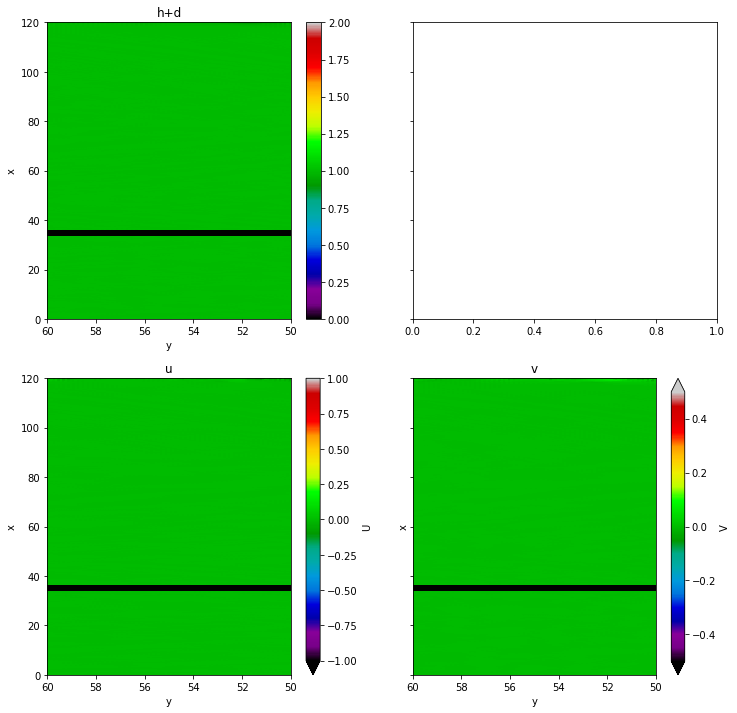

In [28]:
from matplotlib import cm
cmap=cm.nipy_spectral #RdBu_r
cmap.set_bad('gray',1.)
# cmap.set_over('lime',1.)

ita = Data.H + Data.B
ita0 = np.squeeze(ita.sel(time=0, method='nearest'))
h0 = np.squeeze(Data.H.sel(time=0, method='nearest'))
ita = np.squeeze(ita.sel(time=400, method='nearest'))
h = np.squeeze(Data.H.sel(time=400, method='nearest'))
u = np.squeeze(Data.U.sel(time=400, method='nearest'))
v = np.squeeze(Data.V.sel(time=400, method='nearest'))
ita.data[h < 1e-4] = np.nan
u.data[h < 1e-4] = np.nan
v.data[h < 1e-4] = np.nan
h.data[h < 1e-4] = np.nan

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), sharey=True)

ita.T.plot(cmap=cmap, ax=ax[0,0], 
           vmin=0, vmax=2, add_colorbar=True)
ax[0,0].plot([50, 60], [35, 35], color='k', lw=6)
ax[0,0].set_title('h+d')
ax[0,0].set_xlim([60, 50])
# ax[0,0].set_ylim([0, 60])

u.T.plot(cmap=cmap, ax=ax[1,0], 
         vmin=-1, vmax=1, add_colorbar=True)
ax[1,0].plot([50, 60], [35, 35], color='k', lw=6)
ax[1,0].set_title('u')
ax[1,0].set_xlim([60, 50])
# ax[1,0].set_ylim([0, 60])

v.T.plot(cmap=cmap, ax=ax[1,1], 
         vmin=-.5, vmax=.5, add_colorbar=True)
ax[1,1].plot([50, 60], [35, 35], color='k', lw=6)
ax[1,1].set_title('v')
ax[1,1].set_xlim([60, 50])
# ax[1,1].set_ylim([0, 60])


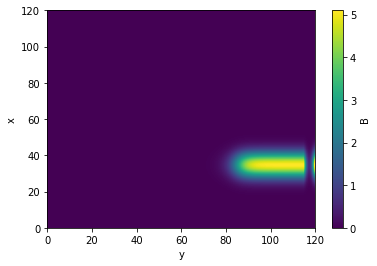

In [29]:
Data.B.T.plot()


# Compute transport: 

Q_c (channel); Q_p (east of plateau)

In [30]:
# if xc is included in x, then we good, or we have to interp to obtain Qc
 # status = 1: need to pickout 2 values if xc cannot be found in x; 
    # status = 0: only get the closest value
    
def same_x(x, xc, status):
    if np.isin(xc, x) == True:
        # index for xc
        ixc = np.where(x == xc)
    else:
        ixc1 = (np.abs(x - xc)).argmin()
        ixc2 = (np.abs(xr.concat([x[ixc1-1], x[ixc1+1]],'x') - xc)).argmin()
        if ixc2 == 0:
            ixc = xr.concat([ixc1, ixc1-1],'x')
        else:
            if status == 1:
                ixc = xr.concat([ixc1, ixc1+1],'x')
            else:
                ixc = ixc1
    return ixc
        

In [31]:
# find the indexes of the xc, and cross-sections of interest: xc-5:xc+5

ixc = same_x(Data.x, Topo.xc, 1)
ixu = same_x(Data.x, Topo.xc - 5, 0)
ixd = same_x(Data.x, Topo.xc + 5, 0)

In [32]:
# compute transport everywhere

h = Data.H[:, :, ixu.data.tolist():ixd.data.tolist()]
u = Data.U[:, : ,ixu.data.tolist():ixd.data.tolist()]
uh = u*h
uh1 = np.squeeze(Data.H[:, :, 0]*Data.U[:, :, 0])

# integrate from y(end): western boundary (uh[:,::-1,:])

# Q_all = uh[:,:,::-1].integrate('y')
from scipy import integrate
Q_all = sp.integrate.cumtrapz(uh[:,::-1,:], Data.y, axis=1) 
Q_all = Q_all[:,::-1,:]

Q_all = np.concatenate((Q_all, np.zeros((Q_all.shape[0], 1, Q_all.shape[-1]))), axis=1)

# Q_all into two parts: within channle and east of plateau

Q_all_duplicate = np.copy(Q_all)
Q_all_duplicate = xr.DataArray(Q_all_duplicate, dims=['time', 'y', 'x'], 
                     coords={'time':np.squeeze(Data.time.data), 
                             'y': np.squeeze(Data.y.data), 
                             'x': np.squeeze(Data.x.data[ixu.data.tolist():ixd.data.tolist()])},
                     attrs={'long_name':'Transport',
                           'description':'start from y=y(end)'})

Q_all[h<1e-7] = np.nan

Q_all = xr.DataArray(Q_all, dims=['time', 'y', 'x'], 
                     coords={'time':np.squeeze(Data.time.data), 
                             'y': np.squeeze(Data.y.data), 
                             'x': np.squeeze(Data.x.data[ixu.data.tolist():ixd.data.tolist()])},
                     attrs={'long_name':'Transport',
                           'description':'start from y=y(end)'})

Q_u = sp.integrate.cumtrapz(uh1[:,::-1], Data.y, axis=1) 
Q_u = Q_u[:,-1]

Notice : x - down to up; y - right to left

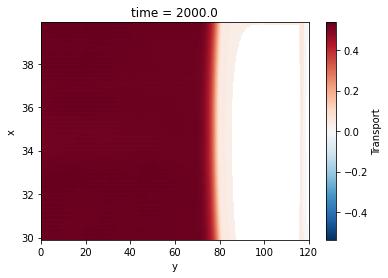

In [33]:
Q_all[-1,:,:].T.plot()

In [34]:
def separate2trans(Q, Q1):
    """
    separate Q (array) into two parts: within channle and east of plateau
    
    NOTE: for channel near x=0 (x direction : towards east)
    """
    
    l = np.where(np.isnan(Q))
    dl = np.diff(l[0])
    # integrate within the channel
#     Q_c = max(Q[l[0][np.where(dl>1)[0]] + 1])
### this allows to pick out a transport at edges h~0
    Q_c = max(Q1[l[0][np.where(dl>1)[0]]])
    # integrate from east of the plateau to the eastern boundary
#     Q_p = Q[0] - Q[l[0][0]-1]
    Q_p = Q[0] - Q1[l[0][0]]
    return np.array([Q_c, Q_p])


In [35]:
# Q_all into two parts: Q_c - within channle, and Q_p - east of plateau

Q_c = np.zeros((Q_all.shape[0], Q_all.shape[-1]))
Q_p = np.zeros((Q_all.shape[0], Q_all.shape[-1]))

# with ProgressBar():
    
for i in range(Q_all.shape[0]):
    for j in range(Q_all.shape[-1]):
        Q_c[i, j] = separate2trans(Q_all[i,:,j].data, 
                                   Q_all_duplicate[i,:,j].data)[0]
        Q_p[i, j] = separate2trans(Q_all[i,:,j].data, 
                                   Q_all_duplicate[i,:,j].data)[-1]

Q_c = xr.DataArray(Q_c, dims=['time', 'x'], 
             coords={'time':np.squeeze(Data.time.data), 
                     'x': np.squeeze(Data.x.data[ixu.data.tolist():ixd.data.tolist()])},
             attrs={'long_name':'Transport of the channel',
                   'description':'start from y=y(end) end at the sill boundary'})

Q_p = xr.DataArray(Q_p, dims=['time', 'x'], 
             coords={'time':np.squeeze(Data.time.data), 
                     'x': np.squeeze(Data.x.data[ixu.data.tolist():ixd.data.tolist()])},
             attrs={'long_name':'Transport east of the plateau',
                   'description':'start from east of plateau end at eastern boundary of domain'})

Q_u = xr.DataArray(Q_u, dims=['time'], 
             coords={'time':np.squeeze(Data.time.data)},
             attrs={'long_name':'Transport at the entrance',
                   'description':'within the whole domain at x = 0'})



In [36]:
# build Dataset (at x)
Q = xr.Dataset({'Q_c': (['time'], Q_c.sel(x=[Topo.xc.data.tolist()], method='nearest')[:,0]),
                'Q_p': (['time'], Q_p.sel(x=[Topo.xc.data.tolist()], method='nearest')[:,0]),
                'Q_u': (['time'], Q_u)},
                 coords={'time': np.squeeze(Data.time.data)},
                 attrs={'title':'Transport at some sections',
                       'description':'sill crest: Q_c (channel), Q_p(east of plateau; Upstream: Q_u (all domain)) '})



# Compute Bernoulli

In [26]:
# Ber=(sqrt(u^2+v^2))^2/2+(d+h)

Ber = (Data.U**2 + Data.V**2)/2 + Data.B + Data.H

h = Data.H
Ber = Ber.data
Ber[h<1e-7] = 0

Ber = xr.DataArray(Ber, dims=['time', 'y', 'x'], 
                coords={'time':np.squeeze(Data.time.data), 
                        'y': np.squeeze(Data.y.data), 
                        'x': np.squeeze(Data.x.data)},
                attrs={'long_name':'Bernoulli function'})

## compute integrated Bernoulli along the channel (upstream-crest-downstream)

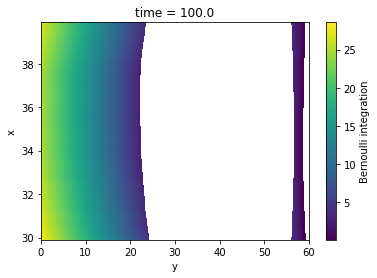

In [27]:
# integrate from y(end): western boundary (B[:,::-1,:])

# B_int_all = B[:,:,::-1].integrate('y')
from scipy import integrate
B_int_all = sp.integrate.cumtrapz(
    Ber[:, ::-1, ixu.data.tolist():ixd.data.tolist()], Data.y, axis=1)
B_int_all = B_int_all[:, ::-1, :]

B_int_all = np.concatenate((B_int_all, np.zeros(
    (B_int_all.shape[0], 1, B_int_all.shape[-1]))), axis=1)

# B_int_all into two parts: within channle and east of plateau

B_int_all_duplicate = np.copy(B_int_all)
B_int_all_duplicate = xr.DataArray(B_int_all_duplicate, dims=['time', 'y', 'x'],
                                   coords={'time': np.squeeze(Data.time.data),
                                           'y': np.squeeze(Data.y.data),
                                           'x': np.squeeze(Data.x.data[ixu.data.tolist():ixd.data.tolist()])},
                                   attrs={'long_name': 'Bernoulli integration',
                                          'description': 'start from y=y(end)'})

B_int_all[Data.H[:, :, ixu.data.tolist():ixd.data.tolist()] < 1e-7] = np.nan

B_int_all = xr.DataArray(B_int_all, dims=['time', 'y', 'x'],
                         coords={'time': np.squeeze(Data.time.data),
                                 'y': np.squeeze(Data.y.data),
                                 'x': np.squeeze(Data.x.data[ixu.data.tolist():ixd.data.tolist()])},
                         attrs={'long_name': 'Bernoulli integration',
                                'description': 'start from y=y(end)'})

B_int_u = sp.integrate.cumtrapz(np.squeeze(Ber[:, ::-1, 0]), Data.y, axis=1)
B_int_u = B_int_u[:, -1]

B_int_all.sel(time=100, method='nearest').T.plot()

In [28]:
# B_int_all into two parts: B_int_c - within channle, and B_int_p - east of plateau

B_int_c = np.zeros((B_int_all.shape[0], B_int_all.shape[-1]))
B_int_p = np.zeros((B_int_all.shape[0], B_int_all.shape[-1]))

# with ProgressBar():

for i in range(B_int_all.shape[0]):
    for j in range(B_int_all.shape[-1]):
        B_int_c[i, j] = separate2trans(B_int_all[i, :, j].data,
                                       B_int_all_duplicate[i, :, j].data)[0]
        B_int_p[i, j] = separate2trans(B_int_all[i, :, j].data,
                                       B_int_all_duplicate[i, :, j].data)[-1]

B_int_c = xr.DataArray(B_int_c, dims=['time', 'x'],
                       coords={'time': np.squeeze(Data.time.data),
                               'x': np.squeeze(Data.x.data[ixu.data.tolist():ixd.data.tolist()])},
                       attrs={'long_name': 'Bernoulli integration of the channel',
                              'description': 'start from y=y(end) end at the sill boundary'})

B_int_p = xr.DataArray(B_int_p, dims=['time', 'x'],
                       coords={'time': np.squeeze(Data.time.data),
                               'x': np.squeeze(Data.x.data[ixu.data.tolist():ixd.data.tolist()])},
                       attrs={'long_name': 'Bernoulli integration east of the plateau',
                              'description': 'start from east of plateau end at eastern boundary of domain'})

B_int_u = xr.DataArray(B_int_u, dims=['time'],
                       coords={'time': np.squeeze(Data.time.data)},
                       attrs={'long_name': 'Bernoulli integration at the entrance',
                              'description': 'within the whole domain at x = 0'})

In [29]:
# build Dataset (at x)
Ber_int = xr.Dataset({'Ber_int_c': (['time', 'x'], B_int_c),
                'Ber_int_p': (['time', 'x'], B_int_p),
                'Ber_int_u': (['time'], B_int_u)},
                 coords={'time': np.squeeze(Data.time.data),
                         'x': np.squeeze(Data.x.data[ixu.data.tolist():ixd.data.tolist()])},
                 attrs={'title':'Bernoulli integration at some sections',
                       'description':'sill crest: Ber_int_c (channel), Ber_int_p(east of plateau; Upstream: Ber_int_u (all domain)) '})

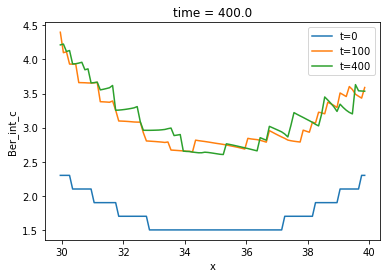

In [30]:
# plt.contour(Ber_int.Ber_int_c.T)
Ber_int.Ber_int_c.sel(time=0, method='nearest').plot(label='t=0')

Ber_int.Ber_int_c.sel(time=100, method='nearest').plot(label='t=100')

Ber_int.Ber_int_c.sel(time=400, method='nearest').plot(label='t=400')

plt.legend()

In [31]:
# prepare data for along-circuit interpolation

Ber = (Data.U**2 + Data.V**2)/2 + Data.B + Data.H

h = Data.H
Ber = Ber.data
Ber[h<1e-7] = np.nan

Ber = xr.DataArray(Ber, dims=['time', 'y', 'x'], 
                coords={'time':np.squeeze(Data.time.data), 
                        'y': np.squeeze(Data.y.data), 
                        'x': np.squeeze(Data.x.data)},
                attrs={'long_name':'Bernoulli function'})

# Compute PV

In [ ]:
# # PV = np.zeros(Data.H.data.shape)
# # curlz = np.zeros(Data.H.data.shape)

# # h = Data.H.data
# # u = Data.U.data
# # v = Data.V.data
# # dx = np.diff(Data.x.data.tolist())[0]
# # dy = np.diff(Data.y.data.tolist())[0]

# # # the original y direction is left to right,
# # # want to shift it and do the derivative
# # u = u[:, ::-1, :]
# # v = v[:, ::-1, :]
# # h = h[:, ::-1, :]

# # u[h < 1e-7] = np.nan
# # v[h < 1e-7] = np.nan
# # h[h < 1e-7] = np.nan

# # curlz[:, 1:-1, 1:-1] = -(u[:, 1:-1, 2:] - u[:, 1:-1, 0:-2])/2/dx + \
# #     (v[:, 2:, 1:-1] - v[:, 0:-2, 1:-1])/2/dy - \
# #     np.ones(u[:, 1:-1, 2:].shape)

# PV = np.zeros(Data.H.data.shape)
# curlz = np.zeros(Data.H.data.shape)

# h = Data.H.data
# u = Data.U.data
# v = Data.V.data
# dx = np.diff(Data.x.data.tolist())[0]
# dy = np.diff(Data.y.data.tolist())[0]

# # the original y [0:60] is correspond to other variables, right to left
# # shift variables so that the channel sit on the left
# u = u[:, ::-1, :]
# v = v[:, ::-1, :]
# h = h[:, ::-1, :]
# # previous v: east to west
# v = -v
# u[h < 1e-7] = np.nan
# v[h < 1e-7] = np.nan
# h[h < 1e-7] = np.nan

# curlz[:, 1:-1, 1:-1] = (u[:, 2:, 1:-1] - u[:, 0:-2, 1:-1])/2/dy - \
#     (v[:, 1:-1, 2:] - v[:, 1:-1, 0:-2])/2/dx
# # # test
# # curlz[:, 1:-1, 1:-1] = (u[:, 2:, 1:-1] - u[:, 0:-2, 1:-1])/2/dy 
# # curlz[:, 1:-1, 1:-1] = - (v[:, 1:-1, 2:] - v[:, 1:-1, 0:-2])/2/dx

# RV = curlz
# RV[:,0,:] =  RV[:,1,:] ; RV[:,-1,:] =  RV[:,-2,:] 
# RV[:,:,0] =  RV[:,:,1] ; RV[:,:,-1] =  RV[:,:,-2] 
# AV = RV - np.ones(RV.shape)
# PV = AV/h

# RV = xr.DataArray(RV, dims=['time', 'y', 'x'], 
#                 coords={'time':np.squeeze(Data.time.data), 
#                         'y': np.squeeze(Data.y.data[::-1]), 
#                         'x': np.squeeze(Data.x.data)},
#                 attrs={'long_name':'RV'})

# AV = xr.DataArray(AV, dims=['time', 'y', 'x'], 
#                 coords={'time':np.squeeze(Data.time.data), 
#                         'y': np.squeeze(Data.y.data[::-1]), 
#                         'x': np.squeeze(Data.x.data)},
#                 attrs={'long_name':'AV'})

# PV = xr.DataArray(PV, dims=['time', 'y', 'x'],
#                   coords={'time': np.squeeze(Data.time.data),
#                           'y': np.squeeze(Data.y.data[::-1]),
#                           'x': np.squeeze(Data.x.data)},
#                   attrs={'long_name': 'PV'})


In [ ]:
# # plot

# from matplotlib import cm

# fig = plt.figure(figsize=(4,6))

# PV.sel(time=[300], method='nearest').T.plot(cmap=cm.RdBu_r,\
#                                        vmin=-2, vmax=0.025\
#                                        , xlim=[60,52], add_colorbar=True)


# Make a Video!

In [ ]:
# # Video of h+b
# # inspired by: http://tech.weatherforce.org/blog/ecmwf-data-animation/index.html
# ita = Data.H + Data.B
    

In [ ]:
# from matplotlib import cm
# import matplotlib.animation as animation

# fig = plt.figure(figsize=(4,6))

# frames = Q_c.shape[0]

# def draw(frame, add_colorbar):
#     ita_i = ita[frame, :, :]
#     contour = ita_i.T.plot(cmap=cm.nipy_spectral, vmin=0.5, vmax=1.6, 
#                            xlim=[60,52], add_colorbar=add_colorbar)
# #     title = u"%s — %s" % (ds.t2m.long_name, str(area.time[frame].values)[:19])
# #     ax.set_title(title)
#     return contour

# def init():
#     return draw(0, add_colorbar=True)


# def animate(frame):
#     return draw(frame, add_colorbar=False)

# ani = animation.FuncAnimation(fig, animate, frames, interval=300, blit=False,
#                               init_func=init, repeat=False)

# # ani.save('/Users/tantanmeow/WORK/2018-2019/Samoan/STan/GillMod_python/ModelOutputs/test.mp4',
# #         writer=animation.FFMpegWriter(fps=8))
# ani.save(outfilepath + 'test.htm')

# # plt.close(fig)


# Data along circuits:

In [32]:
# load circuit
ita = Data.H + Data.B

data = sio.loadmat(Circuit_filepath + Circuit_filename,squeeze_me = True,struct_as_record = False)
x1 = data['x1'] 
y1 = data['y1'] 

x1 = x1[0:S[0]]
y1 = y1[0:S[0]]

# interp ita to along circuit
ita_cir = np.zeros((ita.shape[0], len(x1)))
# Bernoulli
Ber_cir = np.zeros((ita.shape[0], len(x1)))
# bottom elevation
B_cir = np.zeros(len(x1))

for i in range(len(x1)):
    ita_cir[:,i] = np.squeeze(ita.interp(y=y1[i], x=x1[i]).data)
    Ber_cir[:,i] = np.squeeze(Ber.interp(y=y1[i], x=x1[i]).data)
    B_cir[i] = np.squeeze(Data.B.interp(y=y1[i], x=x1[i]).data)

# distance
dx = np.diff(x1)
dy = np.diff(y1)

Dis = np.append([0], np.cumsum(np.sqrt(dx**2 + dy**2)))

ita_cir = xr.DataArray(ita_cir, dims=['time', 'dis'], 
                coords={'time':np.squeeze(Data.time.data), 
                        'dis': Dis},
                attrs={'long_name':'h+b along circuit'})

Ber_cir = xr.DataArray(Ber_cir, dims=['time', 'dis'], 
                coords={'time':np.squeeze(Data.time.data), 
                        'dis': Dis},
                attrs={'long_name':'Bernoulli along circuit'})

B_cir = xr.DataArray(B_cir, dims=['dis'], 
                coords={'dis': Dis},
                attrs={'long_name':'Bottom elevation along circuit'})




In [33]:
# build Dataset (at x)
Circ = xr.Dataset({'ita_cir': (['time', 'dis'], ita_cir),
                'Ber_cir': (['time', 'dis'], Ber_cir),
                'B_cir': (['dis'], B_cir),
                'x1': x1, 
                'y1': y1,
                'S': S},
                 coords={'time': np.squeeze(Data.time.data),
                        'dis': Dis},
                 attrs={'title':'Variables along the circuit',
                       'description':'S1=[S[1]], S2=[S[2]], S3=[S[3]]'})

Out = xr.merge([Circ, Q, Ber_int])


In [37]:
Out=Q

In [38]:
# save thy data

Out.to_netcdf(outfilepath + Out_filename)

In [ ]:
Out = xr.open_dataset(outfilepath + Out_filename)

Out.Q_u.plot(c='k', label='$Q_u$')
(Out.Q_c + Out.Q_p).plot(c='0.4', label='$Q_c+Q_p$')
Out.Q_c.plot(c='r', label='$Q_c$')
Out.Q_p.plot(c='b', label='$Q_p$')

# plt.plot([0, 400], [Q1s[G1, G2], Q1s[G1, G2]], c='r', linestyle='dashed')
# plt.plot([0, 400], [0.5 - Q1s[G1, G2], 0.5 - Q1s[G1, G2]], c='b', linestyle='dashed')
plt.xlim(0,800)
plt.ylim(0,.8)
plt.ylabel('Transport')
plt.grid(True)
plt.legend(loc='best', fontsize=14) #bbox_to_anchor=(1.45,0.6), 
plt.tight_layout()

plt.savefig(outfilepath + 'Trans_' + Expnum + '.png',dpi=200)


In [22]:
t=np.arange(0,400)

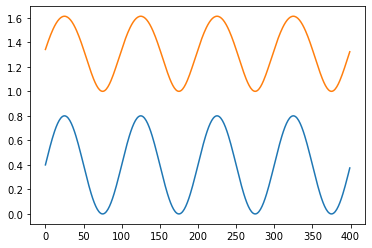

In [23]:
plt.plot(t,0.4+0.4*np.sin(2*np.pi*t/100))
plt.plot(t,np.sqrt(2*(0.4+0.4*np.sin(2*np.pi*t/100))+1))

1.4142135623730951

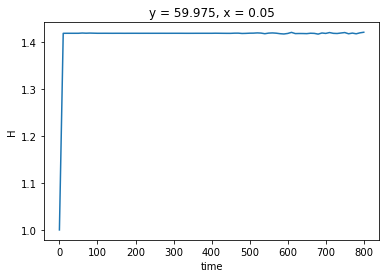

In [24]:
Data.H[:,-1,0].plot()
np.sqrt(2*0.5+1)

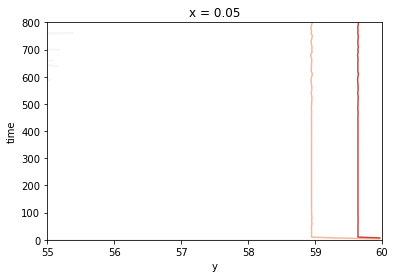

In [25]:
Data.U[:,:,0].plot.contour(xlim=[55,60])